Plan: 
1. Compare normal to spread spectrum with averages over testing set and plot results
2. Fine tune rho parameter using average over testing set for spread spectrum and plot results
3. Run for different tolerances and plot results

In [9]:
import matplotlib.pyplot as plt 
import numpy as np
import torch
import tqdm
import skimage.metrics as metrics
from PIL import Image
import os
import pandas as pd

from M1 import run_admm, rsnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load the testing set images
testing_set_dir = "../../testing_set"
if not os.path.isdir(testing_set_dir):
    raise FileNotFoundError(f"Testing set directory not found: {testing_set_dir}")
testing_files = [os.path.join(testing_set_dir, f) for f in os.listdir(testing_set_dir)]

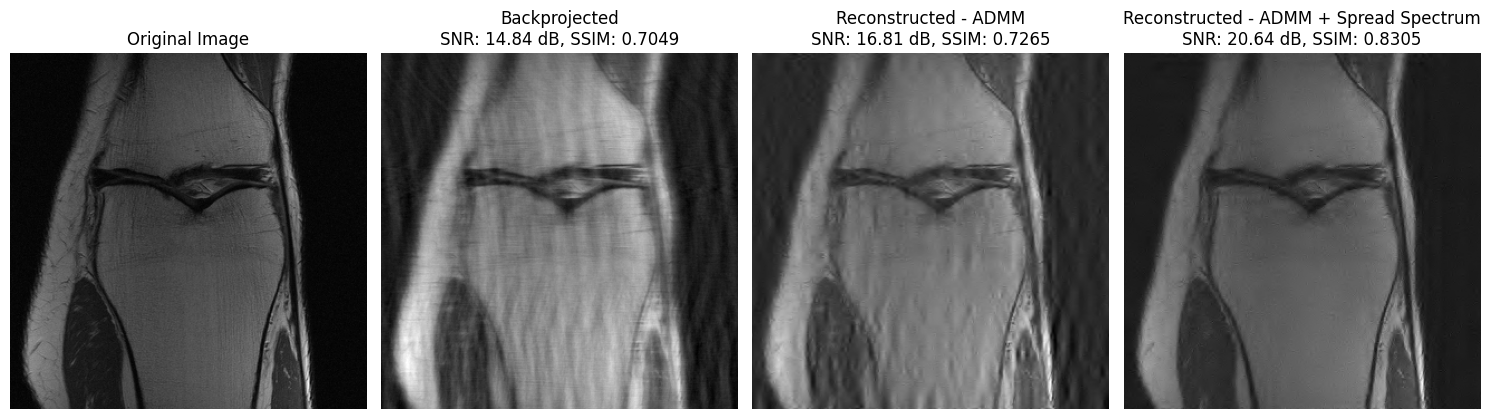

In [7]:
# Visualize original, backprojected, and reconstructed images for the first test image
img_file = testing_files[0]

# Load the original image
img = np.array(Image.open(img_file)).astype(np.float32)
img_torch = torch.tensor(img, dtype=torch.float32, device=device)

# Reconstruct using ADMM
xsol, y_bp, snr_reconstructed, ssim_reconstructed = run_admm(img_file, device, spread_spectrum=False, rho=10)

# Reconstruct using ADMM with spread spectrum
xsol_ss, _, snr_reconstructed_ss, ssim_reconstructed_ss = run_admm(img_file, device, spread_spectrum=True, rho=10)

# Calculate SNR for backprojected image
snr_backprojected = rsnr(y_bp.cpu().numpy(), img)
ssim_backprojected = metrics.structural_similarity(img, y_bp.cpu().numpy(), data_range=img.max() - img.min())

# Plot side by side
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(y_bp.cpu().numpy(), cmap='gray')
axes[1].set_title(f'Backprojected\nSNR: {snr_backprojected:.2f} dB, SSIM: {ssim_backprojected:.4f}')
axes[1].axis('off')

axes[2].imshow(xsol, cmap='gray')
axes[2].set_title(f'Reconstructed - ADMM\nSNR: {snr_reconstructed:.2f} dB, SSIM: {ssim_reconstructed:.4f}')
axes[2].axis('off')

axes[3].imshow(xsol_ss, cmap='gray')
axes[3].set_title(f'Reconstructed - ADMM + Spread Spectrum\nSNR: {snr_reconstructed_ss:.2f} dB, SSIM: {ssim_reconstructed_ss:.4f}')
axes[3].axis('off')

plt.tight_layout()
plt.show()

Trials per rho: 5


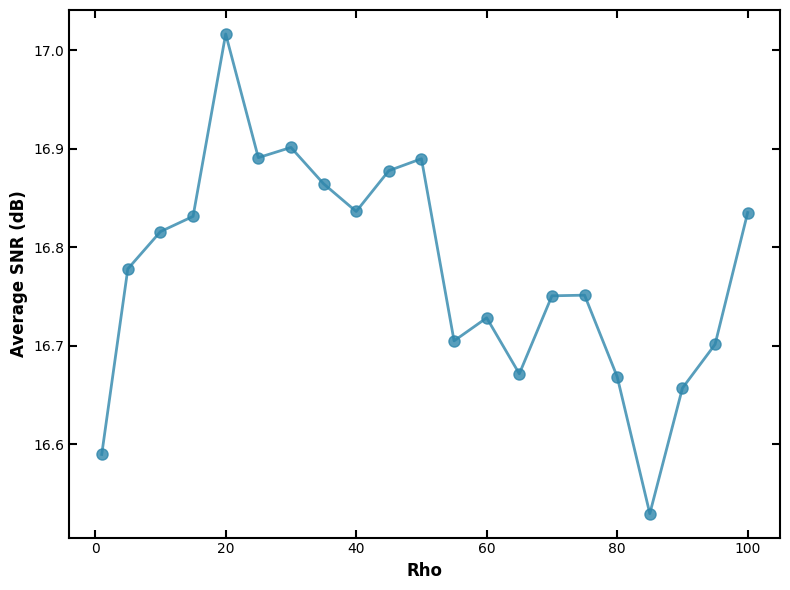


Optimal rho: 20 (SNR: 17.02 dB)


In [14]:
# Apply plot styling function
def apply_plot_style(ax, show_legend=False):
    """Apply consistent styling to a plot axis"""
    ax.grid(False)
    ax.set_facecolor('white')
    
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    
    ax.tick_params(direction='in', length=6, width=1.5, colors='black',
                   which='both', top=True, right=True)

# Load the CSV file
df_rho = pd.read_csv('../results/M1/rho_sweep_results.csv')

# Calculate average SNR for each rho value across all trials
rho_summary = df_rho.groupby('rho')['avg_snr'].mean().reset_index()

print(f"Trials per rho: {df_rho.groupby('rho').size().iloc[0]}")

# Create plot for SNR vs Rho
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig.patch.set_facecolor('white')

# Plot SNR
ax.plot(rho_summary['rho'], rho_summary['avg_snr'], marker='o', color='#2E86AB', 
        linewidth=2, markersize=8, alpha=0.8)
ax.set_xlabel('Rho', fontsize=12, fontweight='bold')
ax.set_ylabel('Average SNR (dB)', fontsize=12, fontweight='bold')

# Apply styling
apply_plot_style(ax)

plt.tight_layout()
plt.show()

# Print optimal rho
best_idx = rho_summary['avg_snr'].idxmax()
best_rho = rho_summary.loc[best_idx, 'rho']
best_snr = rho_summary.loc[best_idx, 'avg_snr']
print(f"\nOptimal rho: {best_rho} (SNR: {best_snr:.2f} dB)")

Loading tolerance sweep results from CSV...
Loaded 35 records
Tolerance values: [np.float64(1e-05), np.float64(5e-05), np.float64(0.0001), np.float64(0.0005), np.float64(0.001), np.float64(0.005), np.float64(0.01)]
Trials per tolerance: 5


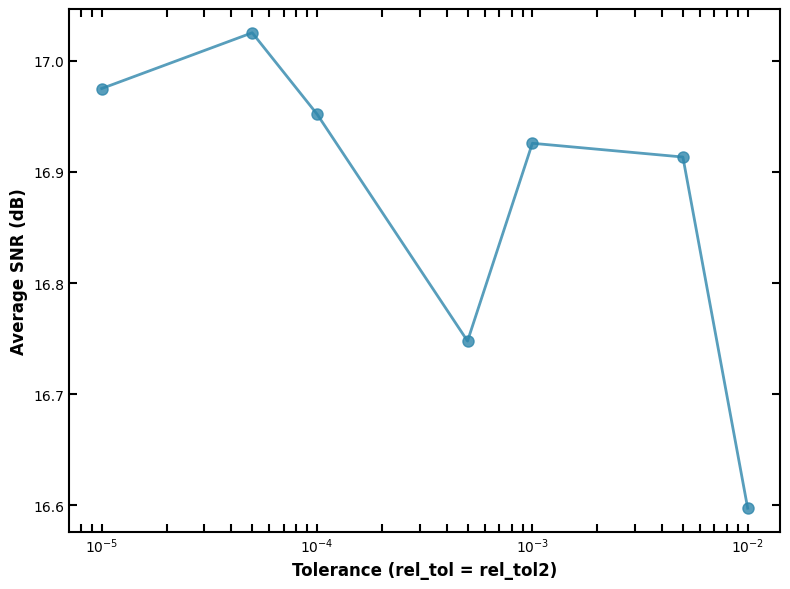


Optimal tolerance: 5e-05 (SNR: 17.03 dB)


In [15]:
# Plot tolerance sweep results from CSV
print("Loading tolerance sweep results from CSV...")

# Load the CSV file
df_tol = pd.read_csv('../results/M1/rel_tol_sweep_results.csv')

# Calculate average SNR for each tolerance value across all trials
tol_summary = df_tol.groupby('rel_tol')['avg_snr'].mean().reset_index()

print(f"Loaded {len(df_tol)} records")
print(f"Tolerance values: {sorted(df_tol['rel_tol'].unique())}")
print(f"Trials per tolerance: {df_tol.groupby('rel_tol').size().iloc[0]}")

# Create plot for SNR vs Tolerance
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig.patch.set_facecolor('white')

# Plot SNR
ax.plot(tol_summary['rel_tol'], tol_summary['avg_snr'], marker='o', color='#2E86AB', 
        linewidth=2, markersize=8, alpha=0.8)
ax.set_xlabel('Tolerance (rel_tol = rel_tol2)', fontsize=12, fontweight='bold')
ax.set_ylabel('Average SNR (dB)', fontsize=12, fontweight='bold')
ax.set_xscale('log')

# Apply styling
apply_plot_style(ax)

plt.tight_layout()
plt.show()

# Print optimal tolerance
best_idx = tol_summary['avg_snr'].idxmax()
best_tol = tol_summary.loc[best_idx, 'rel_tol']
best_snr = tol_summary.loc[best_idx, 'avg_snr']
print(f"\nOptimal tolerance: {best_tol} (SNR: {best_snr:.2f} dB)")

In [18]:
# Analyze timing results from CSV
df_time = pd.read_csv('../results/M1/time_results.csv')

print("Timing Analysis")
print(f"Number of images: {len(df_time)}")
print(f"\nMean SNR: {df_time['snr'].mean():.2f} ± {df_time['snr'].std():.2f} dB")
print(f"Mean SSIM: {df_time['ssim'].mean():.4f} ± {df_time['ssim'].std():.4f}")
print(f"Mean time: {df_time['time_seconds'].mean():.4f} ± {df_time['time_seconds'].std():.4f} seconds")


Timing Analysis
Number of images: 20

Mean SNR: 16.60 ± 1.41 dB
Mean SSIM: 0.6864 ± 0.0583
Mean time: 0.3429 ± 0.1601 seconds
